# Principal Components Analysis (PCA)

## What we will accomplish

In this notebook we will:
- Learn the concept behind PCA,
- Review the mathematics underlying PCA,
- Show how to implement PCA in `sklearn`,
- See how we can attempt to interpret the results of PCA.
- Discuss when it is appropriate or inappropriate to use PCA.

In [5]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a dark background
set_style("whitegrid")

## The intuition behind PCA

PCA looks to reduce the dimension of a data set by projecting the data  onto a lower dimensional space that captures as much of the original variance as possible. Thinking in terms of optimization, your goal is to project into a lower dimensional space in a way that maximizes variance.

Here is a heuristic algorithm:
1. Center your data so that each feature has 0 mean, this is done for convenience.
2. Find the direction in space along which projections have the highest variance, this produces the first principal component.
3. Find the direction orthogonal to the first principal component that maximizes variance, this is the second principal component.
4. Continue in this way, the kth principal component is the variance-maximizing direction orthogonal to the previous k-1 components.

Let's see what we mean in a 2-D example, we will use `sklearn`'s `PCA` object, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html</a>:

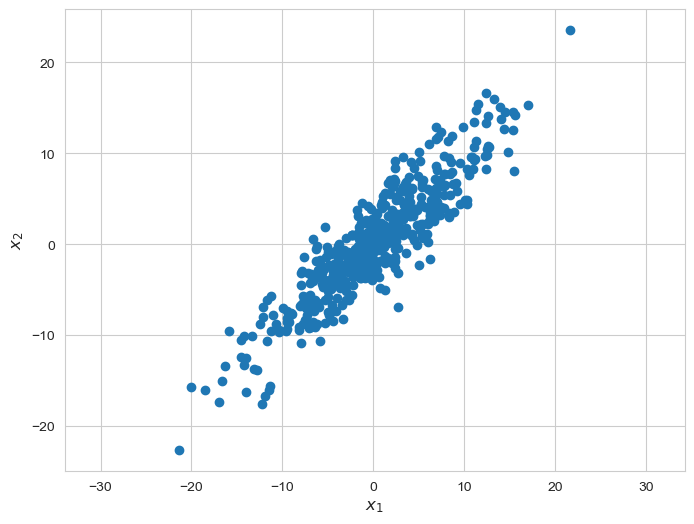

In [6]:
# Make some random data
rng = np.random.default_rng(216)

x1 = 9*rng.standard_normal(500)
x2 = 2*rng.standard_normal(500)

X = np.concatenate([x1.reshape(-1,1),x2.reshape(-1,1)], axis = 1)

angle = -np.pi/4

X = X.dot(np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]]))


plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1])

plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.axis('equal')

plt.show()

In [7]:
## PCA is stored in decomposition
from sklearn.decomposition import PCA

In [8]:
## make the PCA object
## we'll project down to 2-D
pca = PCA(n_components = 2)

## Fit the data
pca.fit(X)

PCA(n_components=2)

In [9]:
pca.components_

array([[ 0.71845985,  0.69556843],
       [-0.69556843,  0.71845985]])

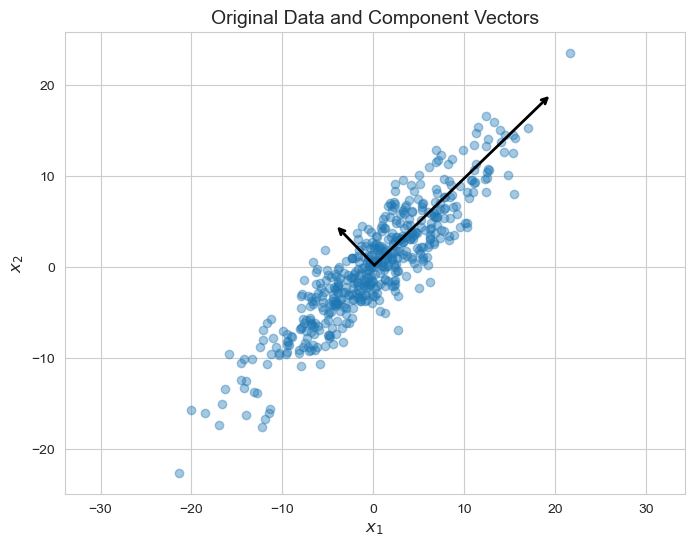

In [10]:
## This function will draw a vector in 2D
## given its components
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, 
                    shrinkB=0,
                    color="black")
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], alpha=.4)

for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
    
    
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.title("Original Data and Component Vectors", fontsize=14)

plt.axis('equal')
plt.show()

The vectors drawn above are called the <i>component vectors</i> of the PCA. When we want to get the transformed version of the data, we get the scalar projection of each observation onto the component vectors. We'll visualize this more explicitly after reviewing the math behind PCA.

In [11]:
# transform gets you the PCA transformed values
fit = pca.transform(X)

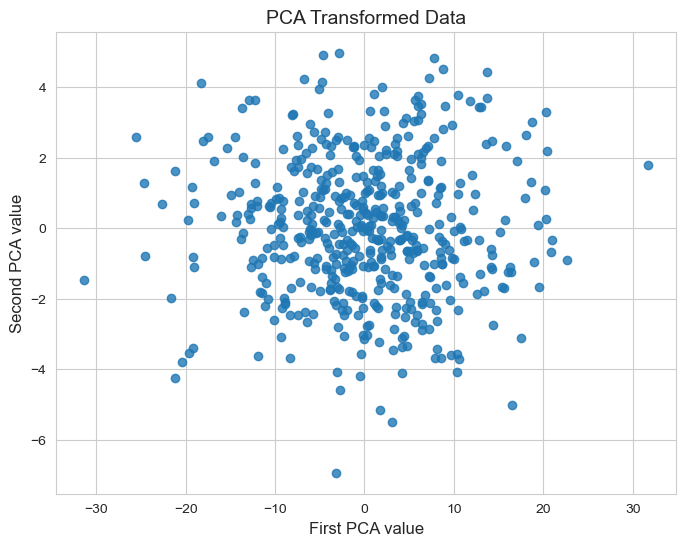

In [12]:
plt.figure(figsize=(8,6))

plt.scatter(fit[:,0], fit[:,1], alpha=.8)

plt.xlabel("First PCA value", fontsize=12)
plt.ylabel("Second PCA value", fontsize=12)

plt.title("PCA Transformed Data", fontsize=14)

plt.show()

## The math behind PCA 

Let $X$ be our design matrix, which we will assume has been centered for simplicity.

Our goal is to find $\vec{w}$ with $||w|| = 1$, such that $\text{Var}( X \vec{w})$ is maximized (note that because $||\vec{w}||=1$, $Xw$ is a vector of scalar projections of the rows of $X$ onto $\vec{w}$).  The following gif (from one of the [best stats.stackoverflow answers of all time](https://stats.stackexchange.com/a/140579/97124)) illustrates our goal geometrically:  we are looking for the direction $\vec{w}$ which maximizes the variance of the projection into that direction.

![SegmentLocal](lecture_assets/pca.gif)

Because we have centered the columns of $X$ we have:

$$
\text{Var}(Xw) = E(w^T X^T X w) = w^T E(X^T X) w = w^T \Sigma w,
$$

where $\Sigma$ is the covariance matrix of $X$.

Our constrained optimization problem is now:

$$
\text{optimize } f(w) = w^T \Sigma w, \text{ constrained to } g(w) = w^T w - 1 = 0.
$$

Using the method of Lagrange multipliers and some matrix calculus:

$$
 \nabla \left(w^T \Sigma w - \lambda (w^T w - 1)\right) = 2 \Sigma w - 2\lambda w.
$$

Setting this equal to $0$ and solving gives
$$
\Sigma w = \lambda w,
$$
the standard eigenvalue setup.

So the vector $w$ that maximizes variance is an eigenvector corresponding to the largest eigenvalue of the covariance matrix of $X$.

This vector is known as the first principal component $\vec{v}_1$.

The $j^{th}$ principle component $\vec{v}_j$ is the direction which maximizes $\operatorname{Var}(X\vec{w})$ subject to $\vec{w} \in \operatorname{Span}(\vec{v}_1, \vec{v}_2, \dots, \vec{v}_{j-1})^\perp$ 

Note because $\Sigma$ is an $p\times p$ real positive symmetric matrix it has a set of $p$ eigenvalues (assuming $n > m$) with orthogonal eigenvectors. It turns out that the principal component vectors are the eigenvectors corresponding to the eigenvalues of $\Sigma$ in decreasing order.

##### Scaling data

We typically need to scale our data prior to fitting the PCA model. This is because the variance of a large scale feature is inherently larger than the variance of a small scale feature. So if we have data with vastly differing scales, we will not be recovering the "hidden structure" of the data, but rather showing what columns have the largest scale. A common scaling approach is to run the data through `StandardScaler` first.

Note that we did not do this here, because our data were constructed to have roughly the same scale.

##### In `sklearn`

In `sklearn`'s `PCA` these $w$ vectors are stored in `PCA().components_`.

We will now use `components_` to more explicitly describe what is going on with PCA.

In [13]:
## demonstrate .components here
pca.components_

## define w1 and w2
w1 = pca.components_[0]
w2 = pca.components_[1]

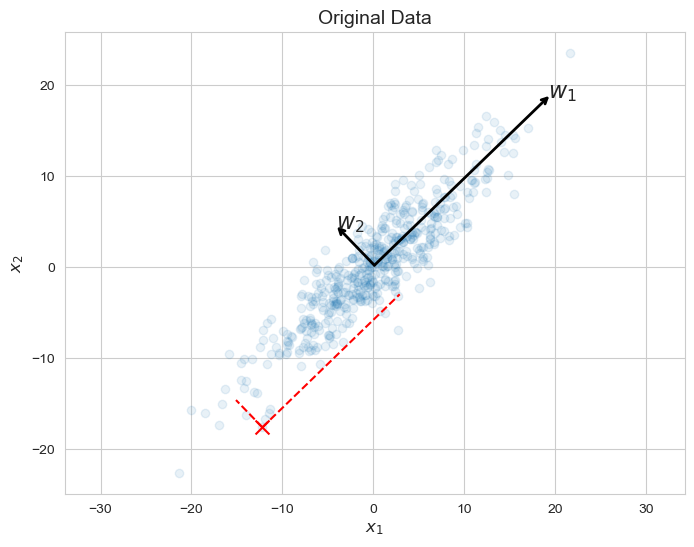

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], alpha=.1)

plt.scatter(X[13, 0], X[13, 1], marker='x', color='r', s=100)

# The scalar projection is (X* dot w1 times w1, X* dot w1 times w1)
plt.plot([X[13,0], X[13,:].dot(w1)*w1[0]], [X[13,1], X[13,:].dot(w1)*w1[1]],'r--')
plt.plot([X[13,0], X[13,:].dot(w2)*w2[0]], [X[13,1], X[13,:].dot(w2)*w2[1]],'r--')

for length, vector, name in zip(pca.explained_variance_, pca.components_, ["$w_1$","$w_2$"]):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
    plt.text(v[0],v[1],name, fontsize=16)
    
    
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.title("Original Data", fontsize=14)


plt.axis('equal')
plt.show()

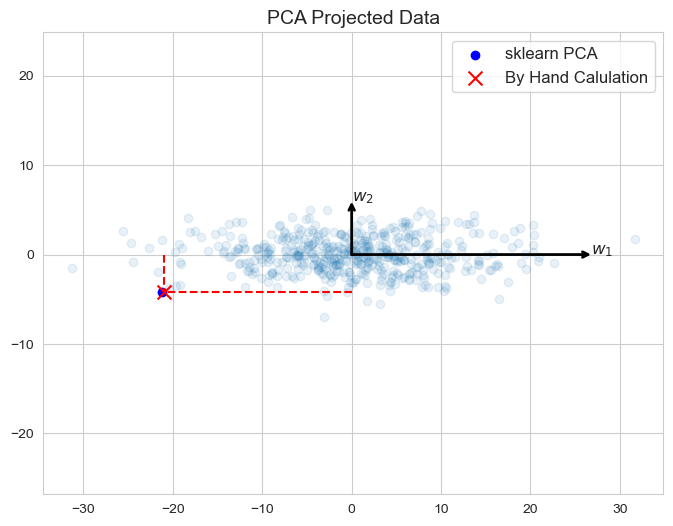

In [15]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

plt.scatter(fit[:, 0], fit[:, 1], alpha=.1)
plt.scatter(fit[13, 0], fit[13, 1], alpha=1, c='b', label="sklearn PCA")

## calculating the PCA projection by hand
plt.scatter(X[13,:].dot(w1), X[13,:].dot(w2), c='r', marker='x', s=100, label="By Hand Calulation")

arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, 
                    shrinkB=0,
                    color="black")
ax.annotate('', [3 * np.sqrt(pca.explained_variance_[0]),0], [0,0], arrowprops=arrowprops)
plt.text(3 * np.sqrt(pca.explained_variance_[0]),0,"$w_1$", fontsize=12)
ax.annotate('', [0, 3 * np.sqrt(pca.explained_variance_[1])], [0,0], arrowprops=arrowprops)
plt.text(0,3 * np.sqrt(pca.explained_variance_[1]),"$w_2$", fontsize=12)
plt.plot([X[13,:].dot(w1),X[13,:].dot(w1)], [0, X[13,:].dot(w2)],'r--')
plt.plot([0,X[13,:].dot(w1)], [X[13,:].dot(w2), X[13,:].dot(w2)],'r--')

plt.legend(fontsize=12)

plt.title("PCA Projected Data", fontsize=14)
plt.axis("equal")

plt.show()

## Explained variance

For each weight vector, $w$, we call $\text{Var}( X w)$ the explained variance due to the principal component $w$. We can think of this as the variance of $X$ explained by the prinicpal component $w$. In `sklearn` we can access this with `explained_variance_`.

In [16]:
## demonstrate explained_variance_
pca.explained_variance_

array([79.67173998,  3.89218357])

At times it can be useful to think of this in terms of the portion of $\text{Var}(X)$ explained by the principal direction, $w$. 
We can access this with `explained_variance_ratio_`.

In [17]:
## demonstrate explained_variance_ratio_
pca.explained_variance_ratio_

array([0.95342268, 0.04657732])

### When to use PCA

1. PCA is useful for **visualizing** your data.

When your data lives in a very high dimensional space, projecting it down to the first two principle components can be useful for visualization purposes.

Here we will see that projecting this 4 dimensional iris data down to the first 2 PCA dimensions nicely distinguishes the classes.

In [18]:
from sklearn.datasets import load_iris

In [19]:
X, y = load_iris(return_X_y=True, as_frame=True)
X.sample(10)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
33,5.5,4.2,1.4,0.2
17,5.1,3.5,1.4,0.3
125,7.2,3.2,6.0,1.8
136,6.3,3.4,5.6,2.4
41,4.5,2.3,1.3,0.3
135,7.7,3.0,6.1,2.3
25,5.0,3.0,1.6,0.2
30,4.8,3.1,1.6,0.2
48,5.3,3.7,1.5,0.2
21,5.1,3.7,1.5,0.4


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([("scale", StandardScaler()), ("pca", PCA(n_components=2))])

pipe.fit(X)

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=2))])

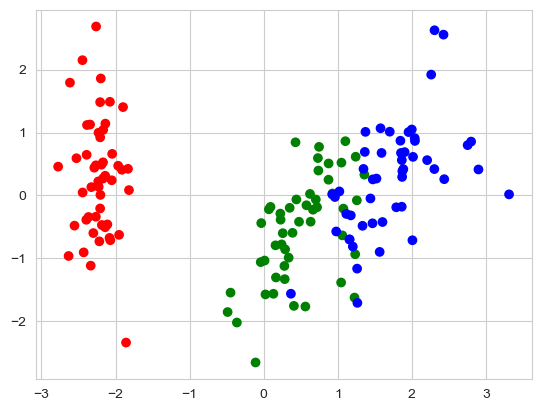

In [21]:
colors = {0:'r', 1:'g', 2:'b'}
plt.scatter(pipe.transform(X)[:,0], pipe.transform(X)[:,1], c = y.map(colors))
plt.show()

2. PCA can be used as a preprocessing step before training any machine learning algorithm if you have reason to believe that the "intrinsic" dimension of your input space is lower than your number of features.  One example is image data:  since the value of nearby pixels in an image tend to be highly correlated, images tend to live in a much lower dimensional subspace than the number of pixels.

Be careful when doing this!  PCA does not look at the $y$ values at all:  it only sees the matrix of features $X$.  It is **entirely possible** that all of the relevant information relating $X$ to $y$ exists in the direction of some small principle components.

Also, as we learned in math hour, ridge regression can be thought of as a "smooth" version of PCA followed by linear regression.  It also (anecdotally) often performs better.  This makes a bit of sense because we can tune our hyperparameter for ridge regression continuously, but PCA forces us to truncate at an integer number of components.

Let's see this in the context of a new dataset.  This data is a cleaned and simplified version of the data from [this study](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0201275)

* 'GS_largest_R':  Grip strength of right hand in kilograms
* 'GS_largest_L':  Grip strength of left hand in kilograms
* 'weight_kg': Subjects weight in kilograms
* 'dominant':  1 means right-handed, 0 means left-handed

In [22]:
df = pd.read_csv('../../data/grip_data.csv', usecols= ['GS_largest_R', 'GS_largest_L', 'dominant', 'weight_kg'])
df.sample(20)


,GS_largest_R,GS_largest_L,weight_kg,dominant
6150,24.4,16.4,59.4,1
5443,23.9,28.4,49.7,0
9659,31.2,38.4,69.1,1
931,22.6,19.3,53.8,1
5733,51.7,52.7,66.0,0
5395,42.3,45.1,66.7,1
8651,31.7,30.8,58.9,1
11072,25.3,19.3,56.3,1
8468,36.3,33.3,54.0,1
5178,22.0,19.2,49.3,1


Two tasks we might be interested in are 
* regressing weight on right and left grip strength measurements
* classifying handedness using the same two features.

Let's look at the two features colored by handedness:

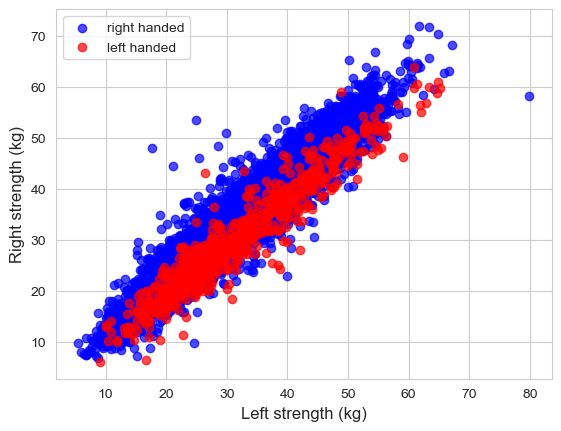

In [23]:
left_hand = (df['dominant'] == 0)
right_hand = (df['dominant'] == 1)
plt.scatter(df['GS_largest_L'][right_hand], df['GS_largest_R'][right_hand], c = 'b', alpha = 0.7, label = 'right handed')
plt.scatter(df['GS_largest_L'][left_hand], df['GS_largest_R'][left_hand], c = 'r', alpha = 0.7, label = 'left handed')

plt.xlabel("Left strength (kg)", fontsize=12)
plt.ylabel("Right strength (kg)", fontsize=12)

plt.legend()
plt.show()

It makes sense that these two features are highly correlated!

You might get a good predictive model for weight by regressing on the first principle component (which should be close to the mean of the left and right handed strength for this example).

However, a classification algorithm which regressed on the first principle component would do horribly!  In this case, the classes seem to be distinguished by their second principle component, not the first.  This also makes intuitive sense, since in this case it looks like the second principle component would record the difference between left and right handed grip strength measurements.

In [24]:
scale = StandardScaler()
pca.fit(scale.fit_transform(df[['GS_largest_L', 'GS_largest_R']]))

PCA(n_components=2)

In [25]:
pca.components_, pca.explained_variance_ratio_

(array([[ 0.70710678,  0.70710678],
        [ 0.70710678, -0.70710678]]),
 array([0.97772349, 0.02227651]))

## References 

<a href = "https://www.tandfonline.com/doi/abs/10.1080/14786440109462720">On lines and planes of closest fit to systems of points in space</a>

<a href="https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf">Univeristy of Waterloo Matrix Cookbook</a>

<a href="http://www.math.kent.edu/~reichel/courses/monte.carlo/alt4.7d.pdf">Kent State University Notes on Random Vectors and Matrices</a>

<a href="http://www.stat.columbia.edu/~fwood/Teaching/w4315/Fall2009/pca.pdf">Columbia PCA notes</a>

<a href="https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf">Central Michigan PCA notes</a>

[Amoeba's PCA explanation](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579)

[Muscular grip strength normative values for a Korean population from the Korea National Health and Nutrition Examination Survey, 2014–2015.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0201275)  by Miji Kim, Chang Won Won, Maengkyu Kim

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)